# Imports

In [1]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, MFCC
from torch_audiomentations import Compose, AddBackgroundNoise

# Loading Data and Creating Dataset Class

- `train_audio/`: short recordings of individual species with labels - *supervised learning*
- `train_soundscapes/`: long recordings without labels - *unsupervised learning*
- `train.csv`: metadata for the training audio


In [2]:
# loading metadata

metadata_path = "data/train.csv"

metadata = pd.read_csv(metadata_path)

print(f"There are {len(metadata['primary_label'].unique())} different species recorded in the train_audio folder.")
print(f"There are a total of {len(metadata)} recordings.")

There are 206 different species recorded in the train_audio folder.
There are a total of 28564 recordings.


### Create a Dataset Class

This class will help us collect the data into a single object, as well as create a label dictionary. Now, each species will be labeled with an integer from 0 to 205.

In [3]:
class AudioDataset(Dataset):
    def __init__(self, metadata_csv: str, audio_dir: str, transform: MelSpectrogram=None):
        """
        metadata_csv: path to train.csv
        audio_dir: path to train_audio/
        transform: transform for waveform
        """
        self.data = pd.read_csv(metadata_csv)
        self.audio_dir = audio_dir
        self.transform = transform

        # sort by alphabetical order, then map species name to label index
        self.classes = sorted(self.data["primary_label"].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get metadata row of specified index
        row = self.data.iloc[idx]

        # construct path to audio file
        audio_path = os.path.join(self.audio_dir, row["filename"])
        try:
            waveform, sample_rate = torchaudio.load(audio_path)
        except:
            print(f"Error loading {audio_path}")
            return torch.zeros(1, 16000), -1 # dummy data if missing file

        # apply any transformation if specified
        if self.transform:
            waveform = self.transform(waveform)

        # get label
        label = self.class_to_idx[row["primary_label"]]

        return waveform, label

# Exploratory Data Analysis

- histograms
- scatter plots 
- allat

In [4]:
# define transform
sample_rate = 8000

mel = MelSpectrogram(sample_rate=sample_rate, n_mels=32) # try different n_mels
mfcc = MFCC(sample_rate=sample_rate, n_mfcc=30)

# initialize dataset & dataloader
dataset = AudioDataset(metadata_csv="data/train.csv", audio_dir="data/train_audio", transform=mel)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

# visualize sample
def spectrogram(sample):
    waveform, label = sample
    # squeeze first dimension to convert from (1, 32, 15817) to (32, 15817)
    spec = waveform.squeeze(0).log2().detach().numpy()
    plt.figure(figsize=(10, 4))
    plt.xlabel('Frames')
    plt.ylabel('Mel bins')
    plt.imshow(spec, aspect='auto', origin='lower')
    plt.title(f"Spectrogram (Label: {sample[1]})")
    plt.colorbar()
    plt.show()
    return spec

In [5]:
sample_rate = 8000

mel = MelSpectrogram(sample_rate=sample_rate, n_mels=32)
mfcc = MFCC(sample_rate=sample_rate, n_mfcc=30)

# initialize dataset & dataloader
dataset = AudioDataset(metadata_csv="data/train.csv", audio_dir="data/train_audio", transform=mel)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

waveform, label = dataset[12]
df = pd.DataFrame(waveform.squeeze(0).detach().numpy()).T
print(df.shape)

(3627, 32)


In [6]:
# remove rows where any column has a value which is an outlier by >3 STD over the column
k = 4
df_means = df.mean()
df_std_devs = df.std()
outliers = ((df - df_means).abs() > (k * df_std_devs)).any(axis=1)

# Remove rows with any outliers
df = df[~outliers]
print(outliers.sum(), "outliers are excluded")

306 outliers are excluded


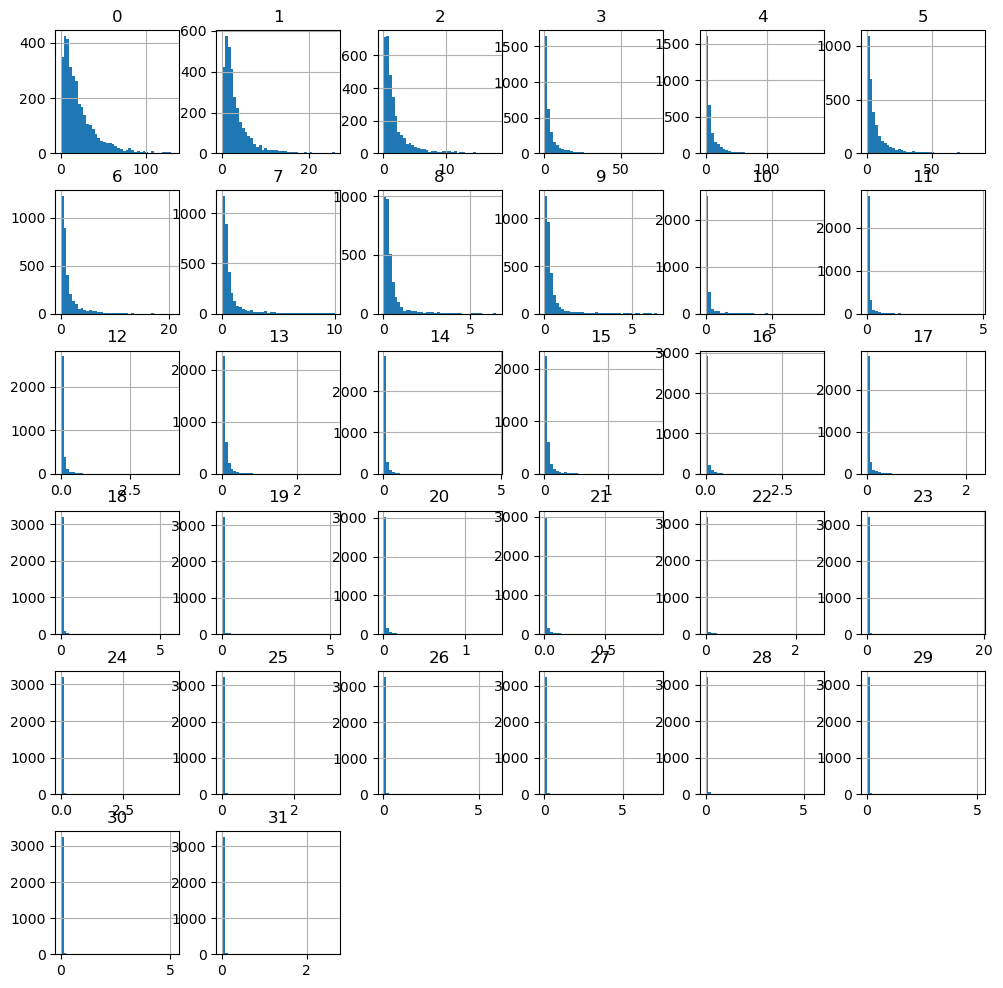

In [7]:
fig = df.hist(figsize=(12, 12), bins=40)

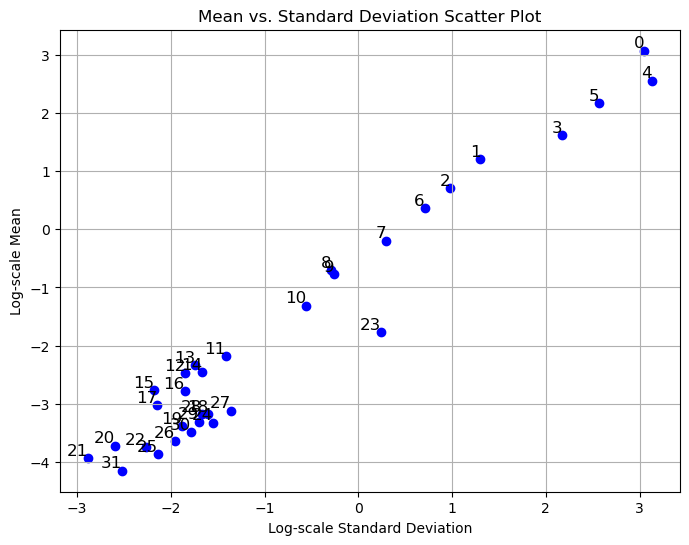

In [8]:
def plot_mean_std(df: pd.DataFrame, log_map=False):
    """Computes the mean and standard deviation for each column
    and plots the two in a scatterplot with labelled axes"""
    means = df.mean()
    std_devs = df.std()
    
    if log_map:
        epsilon = 0.005
        means = np.log(means.abs() + epsilon)
        std_devs = np.log(std_devs + epsilon)

    plt.figure(figsize=(8, 6))
    plt.scatter(std_devs, means, color='b')
    
    for col in df.columns:
        plt.text(std_devs[col], means[col], col, fontsize=12, ha='right', va='bottom')

    plt.ylabel("Log-scale Mean" if log_map else "Mean")
    plt.xlabel("Log-scale Standard Deviation" if log_map else "Standard Deviation")
    plt.title("Mean vs. Standard Deviation Scatter Plot")
    plt.grid(True)

    # Show plot
    plt.show()


plot_mean_std(df[df.columns], True)


# Data Preprocessing

- resampling & normalization
- data augmentation (noise addition, pitch shift, time stretching)

# Feature Extraction

- convert waveform to mel S
- visualize some spectrograms

# Dataset Splitting

- make train/validate/test for train_audio maintaining proportions
- unsupervised learning on soundscapes

# Model Definition

- create the model, define the architecture

# Training & Unsupervised Learning

# Evaluation on Unseen Soundscapes

- accuracy, ROC/AUC, confusion